# Markov Regime Switching Regression Model
_______

## In probability theory, a Markov model is a stochastic model used to model pseudo-randomly changing systems. It is assumed that future states depend only on the current state, not on the events that occurred before it. 
#### Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_model#Introduction)



In [54]:
''' 
Source:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

https://www.statsmodels.org/devel/examples/notebooks/generated/markov_regression.html

'''
# Note: This notebook is work in progress. I have a difficulty with model recognizing data frequency using Date index. I don't think it is crucial since it accounts for all datapoints as sample (see the model summary). Also, still working on all hyper-parameters available and on the optimal time series to be used to fit the model in order to achieve maximum performance.

' \nSource:\n\nhttps://www.statsmodels.org/stable/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html\n\nhttps://www.statsmodels.org/devel/examples/notebooks/generated/markov_regression.html\n\n'

In [55]:
# Import libraries
import numpy as np
import datetime
import warnings
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching import markov_regression

%matplotlib inline

In [56]:
# Read in price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
stock_prices = pd.read_csv("../Resources/stock_historical_prices.csv")
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
stock_prices = stock_prices.set_index('Date')
stock_prices.isna()
# We will use daily returns from 2019-2021
stock_prices = stock_prices.loc['2018':'2021']
stock_prices.head()

,Adj Close
Date,
2018-01-02,253.283142
2018-01-03,254.885162
2018-01-04,255.959488
2018-01-05,257.665283
2018-01-08,258.136414


In [57]:
# Calculate daily return
stock_prices["Return"] = stock_prices['Adj Close'].pct_change()
stock_return = stock_prices["Return"]
stock_return = stock_return.dropna()
stock_return = stock_return.asfreq('B')
stock_return = stock_return.dropna()
stock_return.head()

Date
2018-01-03    0.006325
2018-01-04    0.004215
2018-01-05    0.006664
2018-01-08    0.001828
2018-01-09    0.002263
Name: Return, dtype: float64

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='Date'>

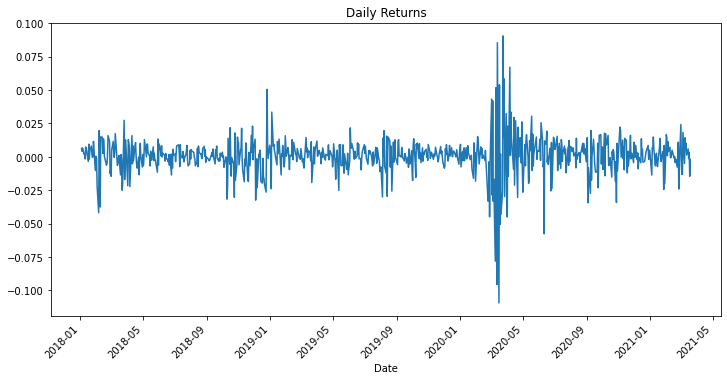

In [58]:
# Plot daily returns
stock_return.plot(title='Daily Returns',figsize=(12,6),rot=45)

In [59]:
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary
adfuller(stock_return)

(-8.411118338972967,
 2.1025534743926435e-13,
 8,
 799,
 {'1%': -3.4385608049885876,
  '5%': -2.865164107438179,
  '10%': -2.5686998068142124},
 -4573.818160660616)

In [60]:
# The series is stationary (the p-value of the ADFuller test is close to 0) and the model can be fit on it.

In [61]:
# Fit the model (we use switching variance in the model, 2 regimes - standard and high, daily stock return, no trend)
mod_high_regime = sm.tsa.MarkovRegression(stock_return, k_regimes=2, trend='nc', switching_variance=True)
res_high_regime = mod_high_regime.fit()
res_high_regime.summary()

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  808
Model:               MarkovRegression   Log Likelihood                2540.596
Date:                Thu, 15 Apr 2021   AIC                          -5073.191
Time:                        00:39:57   BIC                          -5054.413
Sample:                             0   HQIC                         -5065.981
                                - 808                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.407e-05    3.6e-06     12.236      0.000     3.7e-05    5.11e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   7.07e-05      8.425      0.000       0.000       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9736      0.009    111.087      0.000       0.956       0.991
p[1->0]        0.0687      0.025      2.760      0.006       0.020       0.117
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

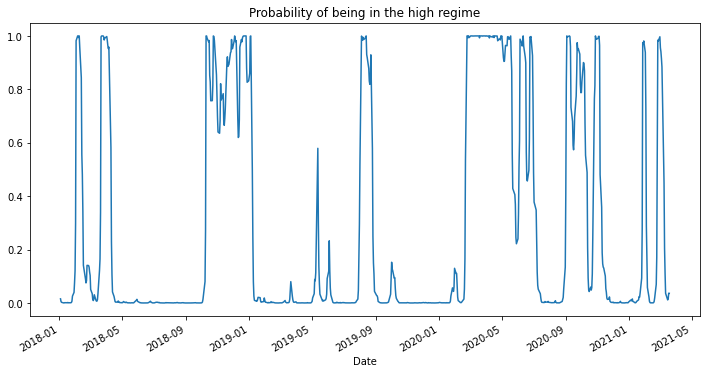

In [62]:
# Plot high regime
res_high_regime.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

<AxesSubplot:title={'center':'Actual Daily Returns'}, xlabel='Date'>

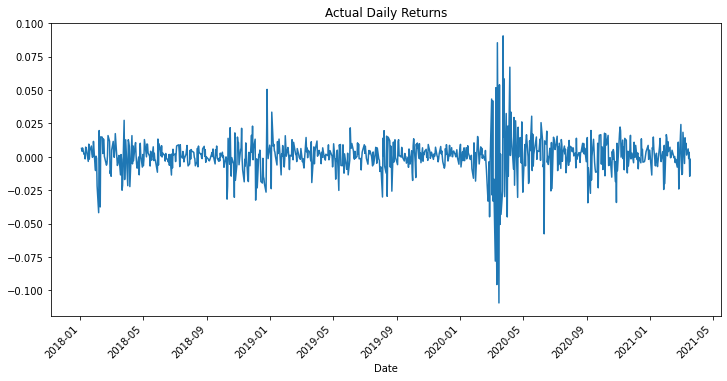

In [63]:
# Plot actual daily returns
actual_return = stock_return.plot(title='Actual Daily Returns',figsize=(12,6),rot=45)
actual_return

In [64]:
# Modify model to include lagged return data
mod_high_regime_2 = sm.tsa.MarkovRegression(stock_return.iloc[1:],k_regimes=2, exog=stock_return.iloc[:-1])
res_high_regime_2 = mod_high_regime_2.fit()
res_high_regime_2.summary()

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  807
Model:               MarkovRegression   Log Likelihood                2382.866
Date:                Thu, 15 Apr 2021   AIC                          -4751.732
Time:                        00:39:58   BIC                          -4718.879
Sample:                             0   HQIC                         -4739.117
                                - 807                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.934      0.350      -0.002       0.001
x1             0.2957      0.088      3.358      0.001       0.123       0.468
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.036      0.002       0.001       0.005
x1            -0.6968      0.071     -9.817      0.000      -0.836      -0.558
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   7.56e-06     18.279      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6329      0.152      4.166      0.000       0.335       0.931
p[1->0]        0.5913      0.090      6.550      0.000       0.414       0.768
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

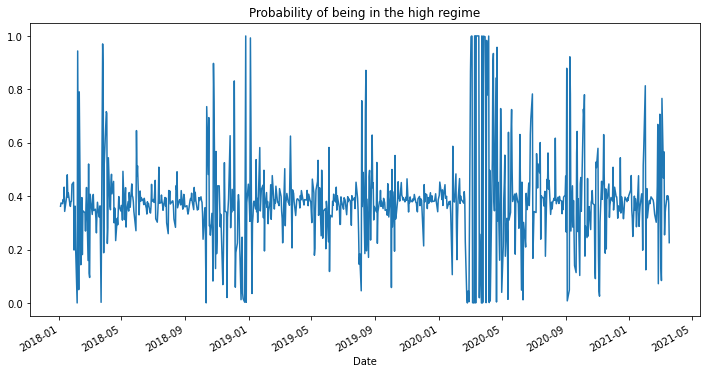

In [74]:
res_high_regime_2.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

In [66]:
prediction = res_high_regime_2.predict()

<AxesSubplot:title={'center':'Predicted Returns'}, xlabel='Date'>

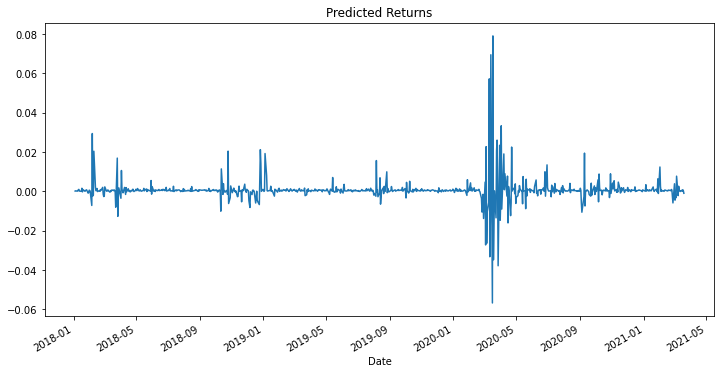

In [75]:
predicted_values = prediction.plot(title='Predicted Returns', figsize=(12,6))
predicted_values

In [76]:
stock_prices["Return"] = stock_prices['Adj Close'].pct_change()
stock_prices
stock_prices['Predicted'] = prediction
stock_prices.dropna()

,Adj Close,Return,Predicted
Date,,,
2018-01-04,255.959488,0.004215,0.000140
2018-01-05,257.665283,0.006664,0.000266
2018-01-08,258.136414,0.001828,0.000089
2018-01-09,258.720703,0.002263,0.000469
2018-01-10,258.324890,-0.001530,0.000423
...,...,...,...
2021-03-15,395.115906,0.005964,0.000544
2021-03-16,394.617523,-0.001261,0.000099
2021-03-17,395.963135,0.003410,0.000806


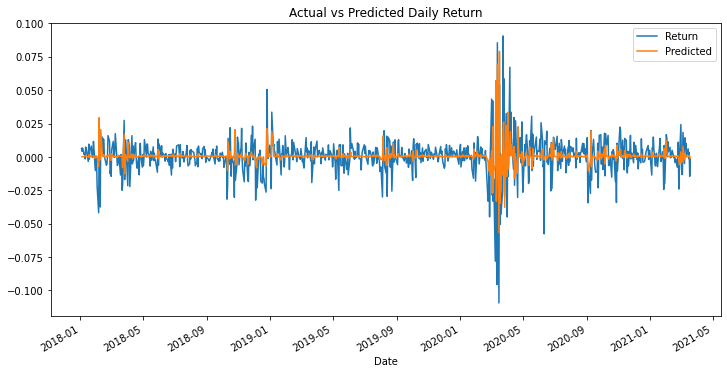

In [77]:
combined = stock_prices[['Return','Predicted']].plot(title='Actual vs Predicted Daily Return', figsize=(12,6))

In [78]:
stock_prices.describe()

,Adj Close,Return,Predicted
count,809.000000,808.000000,807.000000
mean,292.754491,0.000633,0.000626
std,39.085341,0.014148,0.006687
min,219.431061,-0.109424,-0.056772
25%,263.055695,-0.003935,0.000025
50%,280.477051,0.001116,0.000390
75%,317.116211,0.006880,0.000785
max,395.963135,0.090603,0.079050
